Copyright 2022 Fahmi Noor Fiqri

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool

from experiments.helpers import plot_all, print_metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Loading and Feature Engineering

In [2]:
df_train = pd.read_csv('../dataset/house_price_train.csv', parse_dates=["Time"])
df_test = pd.read_csv('../dataset/house_price_test.csv', parse_dates=["Time"])

In [3]:
cat_columns = ["City", "District", "Street", "Community", "Floor"] # "Orient" has too many null values
num_columns = ["#Floors", "#Rooms", "#Halls", "Area"]

In [4]:
# drop unused columns
df_train_pool = df_train.drop(columns=["Id", "Time", "Lat", "Lon", "Orient"])
df_test_pool = df_test.drop(columns=["Id", "Time", "Lat", "Lon", "Orient"])

In [5]:
# standardize price
scaler = StandardScaler()
scaler.fit(df_train_pool["Price"].values.reshape(-1, 1))

df_train_pool["Price"] = scaler.transform(df_train_pool["Price"].values.reshape(-1, 1))
df_test_pool["Price"] = scaler.transform(df_test_pool["Price"].values.reshape(-1, 1))

### Training

In [6]:
X_train, y_train = df_train_pool.iloc[:, :-1], df_train_pool.iloc[:, -1]
X_test, y_test = df_test_pool.iloc[:, :-1], df_test_pool.iloc[:, -1]

cat_cols_idx = [i for i, col in enumerate(X_train.columns) if col in cat_columns]

train_pool = Pool(X_train.values, y_train.values, cat_features=cat_cols_idx)
test_pool = Pool(X_test.values, y_test.values, cat_features=cat_cols_idx)

In [7]:
catboost_model = CatBoostRegressor(task_type="GPU", loss_function='RMSE')
catboost_model.fit(train_pool)

Learning rate set to 0.092389
0:	learn: 0.9465877	total: 51.3ms	remaining: 51.2s
1:	learn: 0.8996045	total: 93.4ms	remaining: 46.6s
2:	learn: 0.8587354	total: 136ms	remaining: 45.3s
3:	learn: 0.8238491	total: 186ms	remaining: 46.2s
4:	learn: 0.7933248	total: 229ms	remaining: 45.6s
5:	learn: 0.7660192	total: 269ms	remaining: 44.6s
6:	learn: 0.7429317	total: 319ms	remaining: 45.3s
7:	learn: 0.7226817	total: 357ms	remaining: 44.3s
8:	learn: 0.7053432	total: 393ms	remaining: 43.2s
9:	learn: 0.6902653	total: 446ms	remaining: 44.1s
10:	learn: 0.6775072	total: 493ms	remaining: 44.3s
11:	learn: 0.6648331	total: 545ms	remaining: 44.9s
12:	learn: 0.6550052	total: 588ms	remaining: 44.7s
13:	learn: 0.6467948	total: 630ms	remaining: 44.4s
14:	learn: 0.6395625	total: 670ms	remaining: 44s
15:	learn: 0.6334178	total: 702ms	remaining: 43.1s
16:	learn: 0.6261150	total: 745ms	remaining: 43.1s
17:	learn: 0.6206044	total: 798ms	remaining: 43.5s
18:	learn: 0.6162185	total: 837ms	remaining: 43.2s
19:	learn: 

In [10]:
catboost_model.save_model("models/catboost.cbm")

In [8]:
predicted = catboost_model.predict(test_pool)
predicted_unscaled = scaler.inverse_transform(predicted.reshape(-1, 1))
y_true_unscaled = scaler.inverse_transform(y_test.values.reshape(-1, 1))

print_metrics(y_true_unscaled, predicted_unscaled)

Min:  3265.1527837681824
Max:  129065.56501628681
R2:  0.6962297060486067
MAPE:  0.2388137707235464
Log MAE:  0.2771416331745635


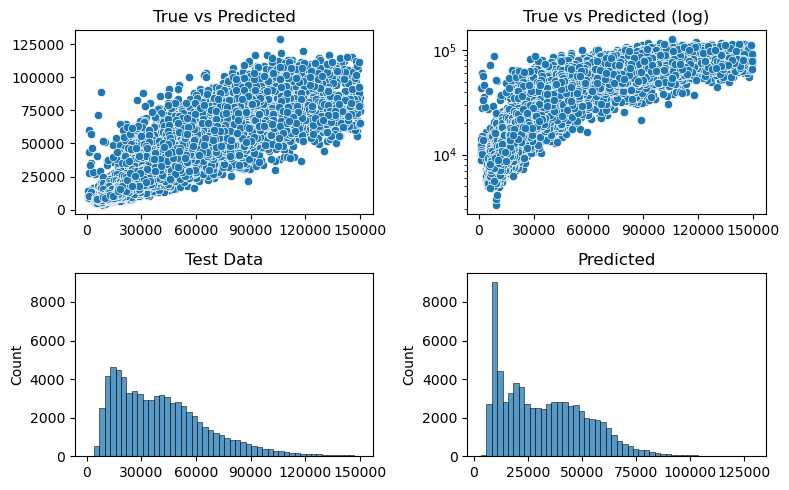

In [21]:
 plot_all(y_true_unscaled, predicted_unscaled, 6)
plt.show()